In [1]:
from cobolt.utils import SingleData, MultiomicDataset
from cobolt.model import Cobolt
import os
import gc
import numpy as np
import pandas as pd
import scipy.sparse as sps
import scanpy as sc
import h5py
import scipy.io as sio
import warnings
from muon import atac as ac
import seaborn as sns

from os.path import join
import matplotlib.pyplot as plt

/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def set_col2cat(ad, cols=[]):
    for col in cols:
        ad.obs[col] = ad.obs[col].astype('category')

def unify_colors(queries, color_key, ref_color_dict):
    for q in queries:
        q.obs[color_key] = q.obs[color_key].astype('category')
        q.uns[f'{color_key}_colors'] = [ref_color_dict[_] for _ in q.obs[color_key].cat.categories]
    return queries

def get_umap(ad, use_reps=[]):
    for use_rep in use_reps:
        umap_add_key = f'{use_rep}_umap'
        sc.pp.neighbors(ad, use_rep=use_rep, n_neighbors=15)
        sc.tl.umap(ad)
        ad.obsm[umap_add_key] = ad.obsm['X_umap']
    return ad

def wrap_warn_plot(adata, basis, color, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        sc.pl.embedding(adata, basis=basis, color=color, **kwargs)

def wrap_warn_comp_plot(ads, basis, colors, figw=5, figh=4, **kwargs):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        for i, color in enumerate(colors):
            _, axes = plt.subplots(1, len(ads), figsize=(figw*len(ads), figh))
            for j, ad in enumerate(ads):
                sc.pl.embedding(ad, basis=basis, color=color, ax=axes[j], show=False, **kwargs)
            plt.show()
            
os.environ['R_HOME'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/R'
os.environ['R_USER'] = '/disco_500t/xuhua/miniforge3/envs/Seurat5/lib/python3.8/site-packages/rpy2'
def mclust_R(adata, num_cluster, modelNames='EEE', used_obsm='STAGATE', random_seed=2020):
    np.random.seed(random_seed)
    import rpy2.robjects as robjects
    robjects.r.library("mclust")

    import rpy2.robjects.numpy2ri
    rpy2.robjects.numpy2ri.activate()
    r_random_seed = robjects.r['set.seed']
    r_random_seed(random_seed)
    rmclust = robjects.r['Mclust']

    res = rmclust(rpy2.robjects.numpy2ri.numpy2rpy(adata.obsm[used_obsm]), num_cluster, modelNames)
    mclust_res = np.array(res[-2])

    adata.obs['mclust'] = mclust_res
    adata.obs['mclust'] = adata.obs['mclust'].astype('int')
    adata.obs['mclust'] = adata.obs['mclust'].astype('category')
    return adata

def load_h5(path):
    with h5py.File(path, 'r') as f:
        print(f['matrix'].keys())
        print(f['matrix']['features'].keys())

        barcodes = [_.decode('utf-8') for _ in f['matrix']['barcodes'][:]]
        data = f['matrix']['data'][:]
        indices = f['matrix']['indices'][:]
        indptr = f['matrix']['indptr'][:]
        shape = f['matrix']['shape'][:]

        feature_type = [_.decode('utf-8') for _ in f['matrix']['features']['feature_type'][:]]
        feature_id   = [_.decode('utf-8') for _ in f['matrix']['features']['id'][:]]
        feature_name = [_.decode('utf-8') for _ in f['matrix']['features']['name'][:]]
        feature_interval = [_.decode('utf-8') for _ in f['matrix']['features']['interval'][:]]


        X = sps.csc_matrix(
            (data, indices, indptr), 
            shape = shape
        ).tocsc().astype(np.float32).T.toarray()

        adata = sc.AnnData(X)
        adata.obs_names = barcodes
        adata.var_names = feature_id
        adata.var['type'] = feature_type
        adata.var['name'] = feature_name
        adata.var['interval'] = feature_interval
    return adata

from scib.metrics import lisi
def eval_lisi(
        adata,
        batch_keys=['domain', 'batch'],
        label_keys = ['gt'],
        use_rep='X_emb', use_neighbors=False,
    ):
    res = {}
    for key in batch_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.ilisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_iLISI'] = _lisi
    for key in label_keys:
        adata.obs[key] = adata.obs[key].astype('category')

        _lisi = lisi.clisi_graph(
            adata,
            key,
            'embed' if not use_neighbors else 'knn',
            use_rep=use_rep,
            batch_key=None,
            k0=90,
            subsample=None,
            scale=True,
            n_cores=1,
            verbose=False,
        )
        res[key+'_cLISI'] = _lisi
    df = pd.DataFrame.from_dict(res, orient='index').T
    # df.columns = [_+'_LISI' for _ in df.columns]
    return df

def eval_ads(ads, ref_key, src_key):
    aris = []
    for ad in ads:
        aris.append(adjusted_rand_score(ad.obs[src_key], ad.obs[ref_key]))
    return aris

from sklearn.preprocessing import normalize
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
def eval_labelTransfer(ad1, ad2, use_rep, lab_key, knn=10):
     with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=FutureWarning)
        neigh1 = KNeighborsClassifier(n_neighbors=knn)
        neigh1.fit(ad1.obsm[use_rep], ad1.obs[lab_key].to_list())
        pr_lab2 = neigh1.predict(ad2.obsm[use_rep])
        f1_1 = f1_score(ad2.obs[lab_key].values, pr_lab2, #labels=['1.0', '2.0', '3.0', '4.0'], 
                        average='macro')
        # acc1 = (pr_lab2 == ad2.obs[lab_key].values).mean()
    
        neigh2 = KNeighborsClassifier(n_neighbors=knn)
        neigh2.fit(ad2.obsm[use_rep], ad2.obs[lab_key].to_list())
        pr_lab1 = neigh2.predict(ad1.obsm[use_rep])
        # acc2 = (pr_lab1 == ad1.obs[lab_key].values).mean()
        f1_2 = f1_score(ad1.obs[lab_key].values, pr_lab1, #labels=['1.0', '2.0', '3.0', '4.0'], 
                        average='macro')
        return (f1_1+f1_2)/2


In [4]:
def split_ob(ads, ad_ref, ob='obs', key='emb2'):
    len_ads = [_.n_obs for _ in ads]
    if ob=='obsm':
        split_obsms = np.split(ad_ref.obsm[key], np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obsms):
            ad.obsm[key] = v
    else:
        split_obs = np.split(ad_ref.obs[key].to_list(), np.cumsum(len_ads[:-1]))
        for ad, v in zip(ads, split_obs):
            ad.obs[key] = v
    
def subset_ad(ad, subset_index):
    ad = ad[subset_index].copy()
    return ad

def set_spatial(ad):
    ad.obsm['spatial'] = ad.obs[['array_row', 'array_col']].values
    ad.obsm['spatial'] = ad.obsm['spatial'][:, ::-1]
    ad.obsm['spatial'][:, 1] = -1 * ad.obsm['spatial'][:, 1]
    return ad

In [5]:
data_dir = '/disco_500t/xuhua/data/MISAR_seq/'
ad_bridge = load_h5(join(data_dir, 'E15_5-S1_raw_feature_bc_matrix.h5'))
ad_test1 = load_h5(join(data_dir, 'E13_5-S1_raw_feature_bc_matrix.h5'))
ad_test2 = load_h5(join(data_dir, 'E18_5-S1_raw_feature_bc_matrix.h5'))  # inconsistent peak name across batches
peak_mat = sps.csr_matrix(sio.mmread(join(data_dir, 'BaiduDisk/section1/peak_mat.mtx')).T)
peak_spot_name = pd.read_csv(join(data_dir, 'BaiduDisk/section1/peak_spot_names.csv')).x.values

meta = pd.read_csv(join(data_dir, 'BaiduDisk/section1/meta_data.csv'), index_col=0)

ad_bridge.obs_names = [f'E15_5-S1#{_}' for _ in ad_bridge.obs_names]
ad_test1.obs_names = [f'E13_5-S1#{_}' for _ in ad_test1.obs_names]
ad_test2.obs_names = [f'E18_5-S1#{_}' for _ in ad_test2.obs_names]

# split rna and peak
ad_bridge_rna = ad_bridge[:, ad_bridge.var['type'] == 'Gene Expression'].copy()
ad_test1_rna = ad_test1[:, ad_test1.var['type'] == 'Gene Expression'].copy()

# subset peak matrices
bridge_mask = np.in1d(peak_spot_name, ad_bridge.obs_names)
ad_bridge_atac = sc.AnnData(peak_mat[bridge_mask])
ad_bridge_atac.obs_names = peak_spot_name[bridge_mask]
test2_mask = np.in1d(peak_spot_name, ad_test2.obs_names)
ad_test2_atac = sc.AnnData(peak_mat[test2_mask])
ad_test2_atac.obs_names = peak_spot_name[test2_mask]

ad_bridge_rna = subset_ad(ad_bridge_rna, ad_bridge_rna.obs_names.intersection(meta.index))
ad_test1_rna = subset_ad(ad_test1_rna, ad_test1_rna.obs_names.intersection(meta.index))

ad_bridge_rna.obs = meta.loc[ad_bridge_rna.obs_names].copy()
ad_bridge_atac.obs = meta.loc[ad_bridge_atac.obs_names].copy()
ad_test1_rna.obs = meta.loc[ad_test1_rna.obs_names].copy()
ad_test2_atac.obs = meta.loc[ad_test2_atac.obs_names].copy()
ad_bridge_rna = set_spatial(ad_bridge_rna)
ad_bridge_atac = set_spatial(ad_bridge_atac)
ad_test1_rna = set_spatial(ad_test1_rna)
ad_test2_atac = set_spatial(ad_test2_atac)

set_col2cat(ad_bridge_rna, cols=['ATAC_Clusters', 'RNA_Clusters', 'Combined_Clusters', 'Sample'])
set_col2cat(ad_bridge_atac, cols=['ATAC_Clusters', 'RNA_Clusters', 'Combined_Clusters', 'Sample'])
set_col2cat(ad_test1_rna, cols=['ATAC_Clusters', 'RNA_Clusters', 'Combined_Clusters', 'Sample'])
set_col2cat(ad_test2_atac, cols=['ATAC_Clusters', 'RNA_Clusters', 'Combined_Clusters', 'Sample'])

del peak_mat, ad_bridge, ad_test1, ad_test2
gc.collect()

<KeysViewHDF5 ['barcodes', 'data', 'features', 'indices', 'indptr', 'shape']>
<KeysViewHDF5 ['_all_tag_keys', 'feature_type', 'genome', 'id', 'interval', 'name']>
<KeysViewHDF5 ['barcodes', 'data', 'features', 'indices', 'indptr', 'shape']>
<KeysViewHDF5 ['_all_tag_keys', 'feature_type', 'genome', 'id', 'interval', 'name']>
<KeysViewHDF5 ['barcodes', 'data', 'features', 'indices', 'indptr', 'shape']>
<KeysViewHDF5 ['_all_tag_keys', 'feature_type', 'genome', 'id', 'interval', 'name']>


26533

In [6]:
ad_bridge_atac = ad_bridge_atac[ad_bridge_rna.obs_names].copy()
assert (ad_bridge_rna.obs_names == ad_bridge_atac.obs_names).all()

In [7]:
ad_rna_all = sc.concat([ad_bridge_rna, ad_test1_rna])
ad_atac_all = sc.concat([ad_bridge_atac, ad_test2_atac])

sc.pp.highly_variable_genes(ad_rna_all, flavor='seurat_v3', n_top_genes=10000, batch_key='Sample')
hvg_names = ad_rna_all.var.query('highly_variable').index.to_numpy()

In [8]:
# ac.pp.tfidf(ad_atac_all, scale_factor=1e4)
sc.pp.highly_variable_genes(ad_atac_all, flavor='seurat_v3', n_top_genes=50000, batch_key='Sample')

hvp_names = ad_atac_all.var.query('highly_variable').index.to_numpy()

In [9]:
# mult_rna_count = ad_bridge_rna[:, hvg_names].layers["counts"].astype(np.float32)
# mult_atac_count = ad_bridge_atac[:, hvp_names].layers["counts"].astype(np.float32)
mult_rna_count = ad_bridge_rna[:, hvg_names].X.astype(np.float32)
mult_atac_count = ad_bridge_atac[:, hvp_names].X.astype(np.float32)
mult_rna_count = sps.csr_matrix(mult_rna_count)  
mult_atac_count = sps.csr_matrix(mult_atac_count)   # slowly, fuck, fuck, fuck
mult_barcode = ad_bridge_rna.obs_names.to_numpy()

rna_feature = hvg_names
atac_feature = hvp_names

In [10]:
mult_rna = SingleData("GeneExpr", "Multiome", rna_feature, mult_rna_count, mult_barcode)
mult_atac = SingleData("ATAC", "Multiome", atac_feature, mult_atac_count, mult_barcode)

In [11]:
single_rna_count = ad_test1_rna[:, hvg_names].X.astype(np.float32)
single_atac_count = ad_test2_atac[:, hvp_names].X.astype(np.float32)
single_rna_count = sps.csr_matrix(single_rna_count)
single_atac_count = sps.csr_matrix(single_atac_count)
single_rna_barcode = ad_test1_rna.obs_names.to_numpy()
single_atac_barcode = ad_test2_atac.obs_names.to_numpy()

rna_feature = hvg_names
atac_feature = hvp_names

In [12]:
single_rna = SingleData("GeneExpr", "Single-GEX", rna_feature, single_rna_count, single_rna_barcode)
single_atac = SingleData("ATAC", "Single-ATAC", atac_feature, single_atac_count, single_atac_barcode)

In [13]:
multi_dt = MultiomicDataset.from_singledata(
    single_rna, single_atac, mult_atac, mult_rna)
print(multi_dt)

A MultiomicDataset object with 2 omics:
- GeneExpr: 10000 features, 3726 cells, 2 batches.
- ATAC: 50000 features, 4078 cells, 2 batches.
Joint cells:
- GeneExpr, ATAC: 1949 cells.


### Training

In [13]:
model = Cobolt(dataset=multi_dt, lr=0.001, n_latent=10, batch_size=128) 
model.train(num_epochs=100)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:58<00:00,  2.98s/it]


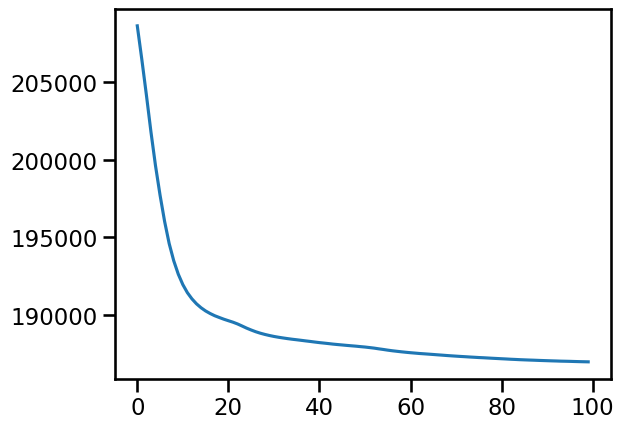

In [14]:
plt.plot(model.history['loss'])

In [15]:
model.calc_all_latent()

latent = model.get_all_latent()

In [14]:
if False:
    latent_barcode = np.array([_.split('~')[1] for _ in latent[1]])
    df_latent = pd.DataFrame(latent[0], index=latent_barcode)
    df_latent.to_csv('./outputs/misar_seq/E15-13-18.csv')

else:
    df_latent = pd.read_csv('./outputs/misar_seq/E15-13-18.csv', index_col=0)
    df_latent.index = df_latent.index.astype('str')

In [15]:
ad_bridge_rna.obsm['X_emb'] = df_latent.loc[ad_bridge_rna.obs_names, :].values
ad_test1_rna.obsm['X_emb'] = df_latent.loc[ad_test1_rna.obs_names, :].values
ad_test2_atac.obsm['X_emb'] = df_latent.loc[ad_test2_atac.obs_names, :].values

In [16]:
ad_mosaic = sc.concat([ad_bridge_rna, ad_test1_rna, ad_test2_atac], label='src', keys=['E15', 'E13', 'E18'])
ad_mosaic = get_umap(ad_mosaic, ['X_emb'])

try:
    
    # from sklearn.cluster import KMeans
    # print("mclust failed, try kmeans")
    # kmeans = KMeans(n_clusters=ad_mosaic.obs['Combined_Clusters_annotation'].nunique(), random_state=0).fit(ad_mosaic.obsm['X_emb'])
    # ad_mosaic.obs['kmeans'] = kmeans.labels_.astype('str')
    # clust_key = 'kmeans'

    ad_mosaic = mclust_R(ad_mosaic, ad_mosaic.obs.Combined_Clusters_annotation.nunique(), used_obsm='X_emb')  
    clust_key = 'mclust'
    
except:

    ad_mosaic = mclust_R(ad_mosaic, ad_mosaic.obs.Combined_Clusters_annotation.nunique(), used_obsm='X_emb')  
    clust_key = 'mclust'

split_ob([ad_bridge_rna, ad_test1_rna, ad_test2_atac], ad_mosaic, ob='obs', key=clust_key)

R[write to console]:                    __           __ 
   ____ ___  _____/ /_  _______/ /_
  / __ `__ \/ ___/ / / / / ___/ __/
 / / / / / / /__/ / /_/ (__  ) /_  
/_/ /_/ /_/\___/_/\__,_/____/\__/   version 6.0.1
Type 'citation("mclust")' for citing this R package in publications.



fitting ...
  |                                                                      |   0%

/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/rpy2/robjects/numpy2ri.py:252: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


  |======================================================================| 100%


In [17]:
ad_mosaic.obs['before_clust'] = ad_mosaic.obs[clust_key].to_list()

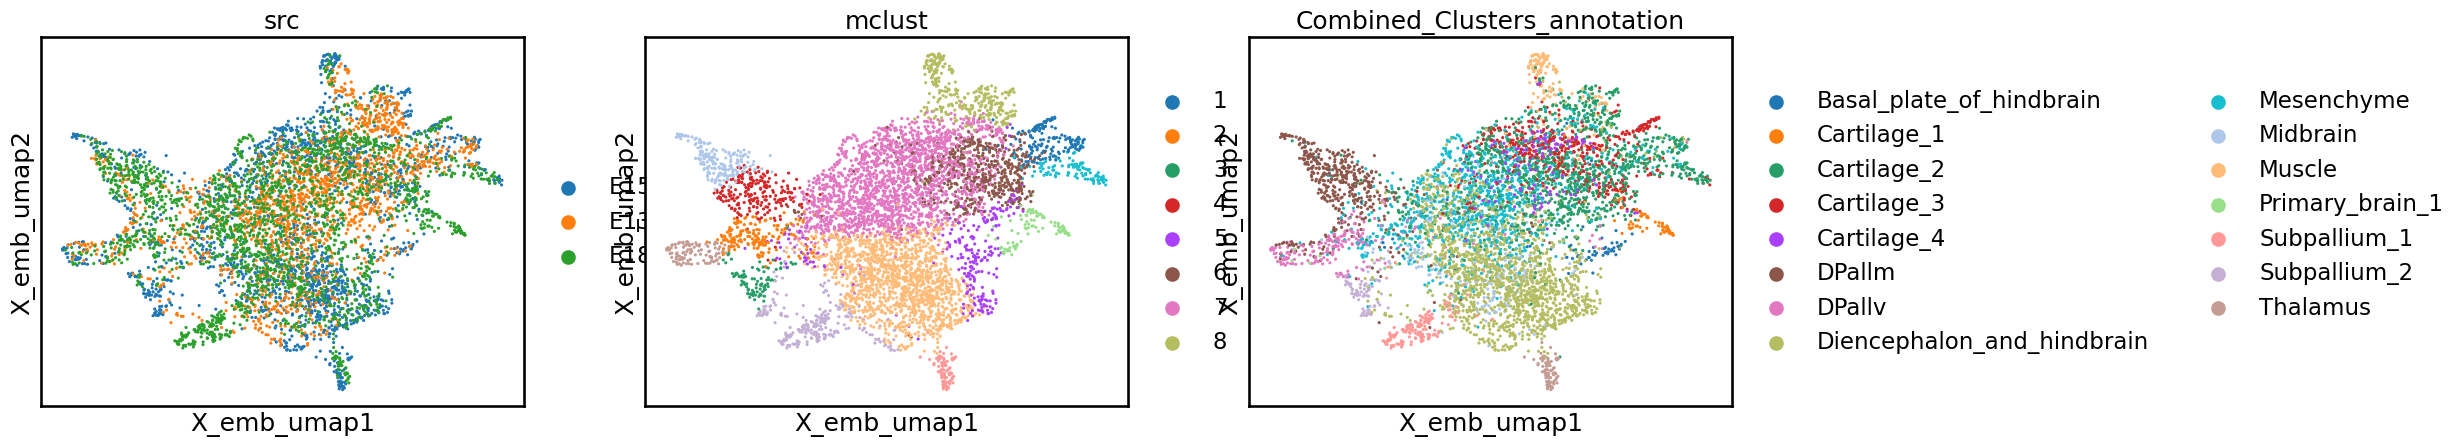

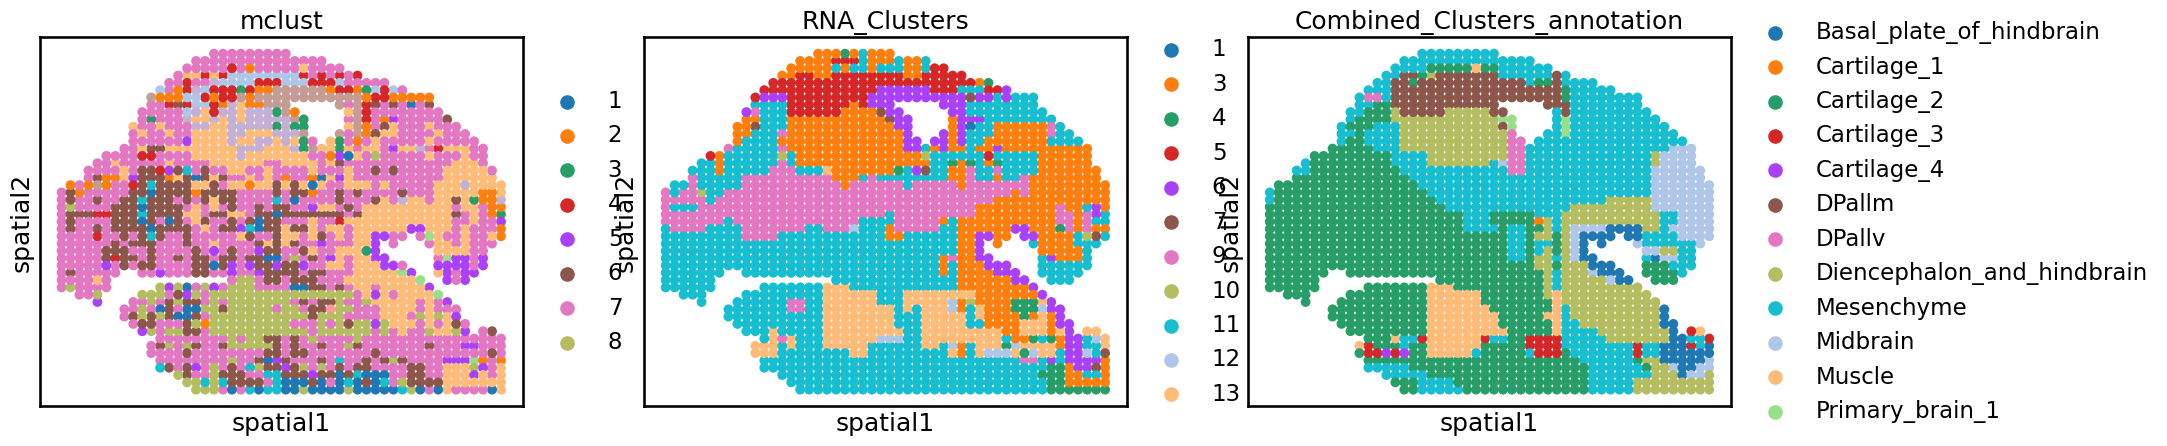

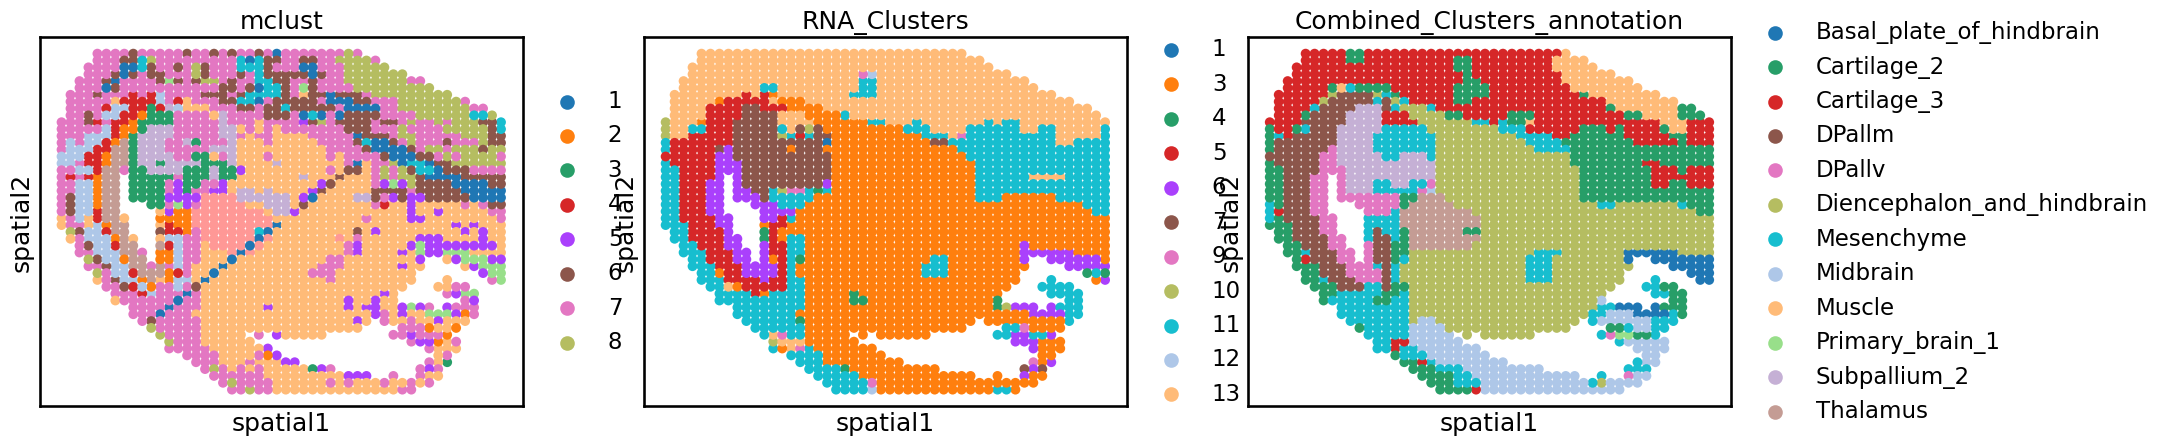

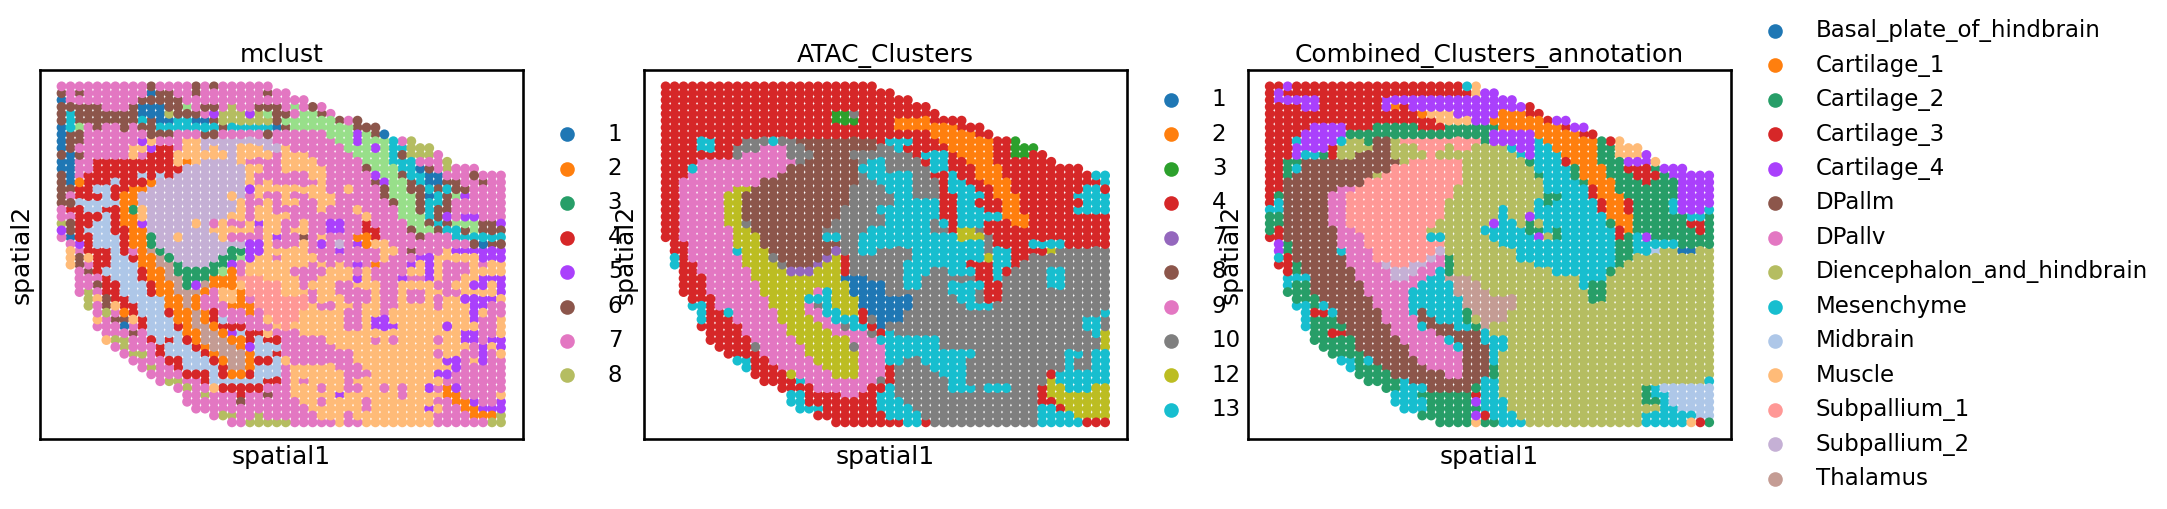

In [19]:
# plot
wrap_warn_plot(ad_mosaic, 'X_emb_umap', ['src', 'mclust', 'Combined_Clusters_annotation'])

# unify type colors
mclust_type2dict = dict(zip(ad_mosaic.obs.mclust.cat.categories, ad_mosaic.uns['mclust_colors']))
label_type2dict = dict(zip(ad_mosaic.obs.Combined_Clusters_annotation.cat.categories, ad_mosaic.uns['Combined_Clusters_annotation_colors']))
ad_bridge_rna, ad_test1_rna, ad_test2_atac = unify_colors(
    [ad_bridge_rna, ad_test1_rna, ad_test2_atac], 'mclust', mclust_type2dict)
ad_bridge_rna, ad_test1_rna, ad_test2_atac = unify_colors(
    [ad_bridge_rna, ad_test1_rna, ad_test2_atac], 'Combined_Clusters_annotation', label_type2dict)

s=200
wrap_warn_plot(ad_test1_rna, 'spatial', ['mclust', 'RNA_Clusters', 'Combined_Clusters_annotation'], s=s)
wrap_warn_plot(ad_bridge_rna, 'spatial', ['mclust', 'RNA_Clusters', 'Combined_Clusters_annotation'], s=s)
wrap_warn_plot(ad_test2_atac, 'spatial', ['mclust', 'ATAC_Clusters', 'Combined_Clusters_annotation'], s=s)

In [16]:
### evaluation
from sklearn.metrics import adjusted_rand_score

r1 = eval_ads([ad_mosaic, ad_bridge_rna, ad_test1_rna, ad_test2_atac], 'Combined_Clusters_annotation', clust_key)
r1

[0.2512957101410874,
 0.40951244520812985,
 0.12807890242771414,
 0.3593741195719656]

In [17]:
lisi_res = eval_lisi(
    ad_mosaic,
    batch_keys=['src'],
    label_keys = [],
    use_rep='X_emb', use_neighbors=False,
)
lisi_res['src_iLISI'][0]

0.5371421125296529

In [18]:
r4 = eval_labelTransfer(ad_test1_rna, ad_test2_atac, 'X_emb', 'Combined_Clusters_annotation', knn=10)
r4

0.1672836380400993

### batch corr

In [18]:
from batchCorr import HARMONY

ad_mosaic.obsm['X_emb_har'] = HARMONY(pd.DataFrame(ad_mosaic.obsm['X_emb']), ad_mosaic.obs['src'].to_list())
ad_mosaic = get_umap(ad_mosaic, ['X_emb_har'])
split_ob([ad_bridge_rna, ad_test1_rna, ad_test2_atac], ad_mosaic, ob='obsm', key='X_emb_har')

Use GPU mode.
	Initialization is completed.
	Completed 1 / 10 iteration(s).
	Completed 2 / 10 iteration(s).
	Completed 3 / 10 iteration(s).
	Completed 4 / 10 iteration(s).
	Completed 5 / 10 iteration(s).
	Completed 6 / 10 iteration(s).
	Completed 7 / 10 iteration(s).
	Completed 8 / 10 iteration(s).
Reach convergence after 8 iteration(s).


In [19]:
try:
    
    # from sklearn.cluster import KMeans
    # print("mclust failed, try kmeans")
    # kmeans = KMeans(n_clusters=ad_mosaic.obs['Combined_Clusters_annotation'].nunique(), random_state=0).fit(ad_mosaic.obsm['X_emb_har'])
    # ad_mosaic.obs['kmeans'] = kmeans.labels_.astype('str')
    # clust_key = 'kmeans'

    ad_mosaic = mclust_R(ad_mosaic, ad_mosaic.obs.Combined_Clusters_annotation.nunique(), used_obsm='X_emb_har')  
    clust_key = 'mclust'
    
except:

    ad_mosaic = mclust_R(ad_mosaic, ad_mosaic.obs.Combined_Clusters_annotation.nunique(), used_obsm='X_emb_har')  
    clust_key = 'mclust'

split_ob([ad_bridge_rna, ad_test1_rna, ad_test2_atac], ad_mosaic, ob='obs', key=clust_key)

fitting ...
  |                                                                      |   0%

/home/xuhua/xuhua_disco/miniforge3/envs/Squidpy/lib/python3.8/site-packages/rpy2/robjects/numpy2ri.py:252: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '


  |======================================================================| 100%


In [20]:
ad_mosaic.obs['after_clust'] = ad_mosaic.obs[clust_key].to_list()

In [24]:
r1 = eval_ads([ad_mosaic, ad_bridge_rna, ad_test1_rna, ad_test2_atac], 'Combined_Clusters_annotation', clust_key)
lisi_res = eval_lisi(
    ad_mosaic,
    batch_keys=['src'],
    label_keys = [],
    use_rep='X_emb_har', use_neighbors=False,
)
r2 = lisi_res['src_iLISI'][0]

r4 = eval_labelTransfer(ad_test1_rna, ad_test2_atac, 'X_emb_har', 'Combined_Clusters_annotation', knn=10)
r4

0.15461685079398213

In [25]:
r1, r2, r4

([0.19453221656646164,
  0.2948513720931038,
  0.08355242237177658,
  0.3237127658573239],
 0.7432677560502627,
 0.15461685079398213)

### Vis

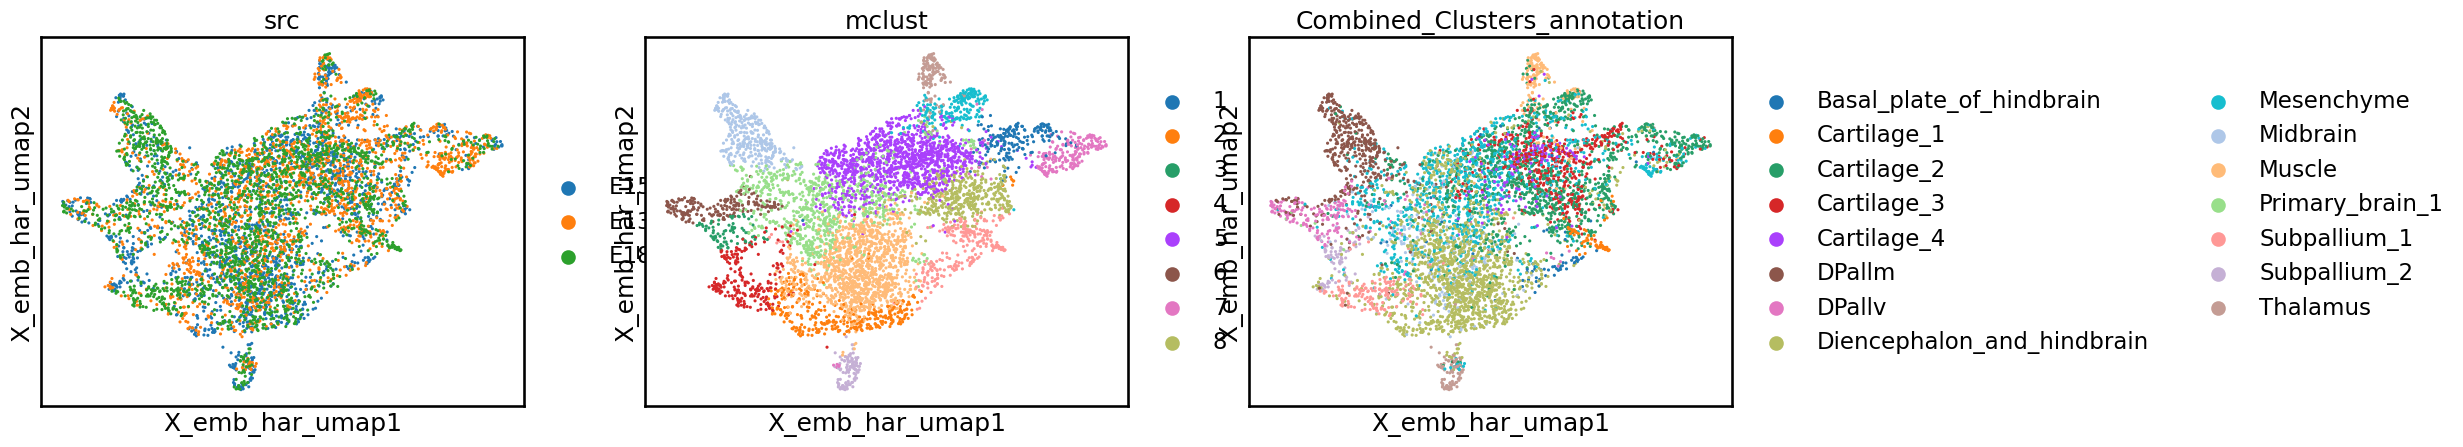

In [22]:
wrap_warn_plot(ad_mosaic, 'X_emb_har_umap', ['src', 'mclust', 'Combined_Clusters_annotation'])

# unify type colors
mclust_type2dict = dict(zip(ad_mosaic.obs.mclust.cat.categories, ad_mosaic.uns['mclust_colors']))
label_type2dict = dict(zip(ad_mosaic.obs.Combined_Clusters_annotation.cat.categories, ad_mosaic.uns['Combined_Clusters_annotation_colors']))
ad_bridge_rna, ad_test1_rna, ad_test2_atac = unify_colors(
    [ad_bridge_rna, ad_test1_rna, ad_test2_atac], 'mclust', mclust_type2dict)
ad_bridge_rna, ad_test1_rna, ad_test2_atac = unify_colors(
    [ad_bridge_rna, ad_test1_rna, ad_test2_atac], 'Combined_Clusters_annotation', label_type2dict)

In [21]:
fig_dir = f'/disco_500t/xuhua/gitrepo/BridgeNorm/figures/misar_seq/E15-13-18/cobolt'
os.makedirs(fig_dir, exist_ok=True)

df = pd.DataFrame(ad_mosaic.obsm['X_emb'], index=ad_mosaic.obs_names)
df['before_clust'] = ad_mosaic.obs['before_clust'].to_list() 
df.to_csv(join(fig_dir, 'X_emb.csv'))

df = pd.DataFrame(ad_mosaic.obsm['X_emb_har'], index=ad_mosaic.obs_names)
df['after_clust'] = ad_mosaic.obs['after_clust'].to_list() 
df.to_csv(join(fig_dir, 'X_emb_har.csv'))

In [71]:
import squidpy as sq
def eval_clust_moran(ad, eval_obs, coord_type='generic', **kwargs):
    gene_data = []
    for col in eval_obs:
        if pd.api.types.is_numeric_dtype(ad.obs[col]):
            gene_data.append(ad.obs[col].to_list())
        else:
            gene_data.append(ad.obs[col].astype('category').cat.codes)
            
    gene_data = np.hstack(gene_data).reshape(len(eval_obs), -1).T
    ad_holder = sc.AnnData(gene_data, obsm={'spatial':ad.obsm['spatial']})
    ad_holder.var_names = eval_obs
    
    sq.gr.spatial_neighbors(ad_holder, coord_type=coord_type, **kwargs)
    sq.gr.spatial_autocorr(
        ad_holder,
        mode="moran",
        genes=eval_obs,
        n_perms=100,
        n_jobs=1,
    )
    return ad_holder.uns["moranI"]

In [74]:
eval_clust_moran(ad_bridge_rna, ['Combined_Clusters_annotation', 'mclust'], 'grid', n_neighs=8)  # n_neighs should be customized
# it's rectangular grid, n_neighs should be 8

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:12<00:00,  8.11/s]


,I,pval_norm,var_norm,pval_z_sim,pval_sim,var_sim,pval_norm_fdr_bh,pval_z_sim_fdr_bh,pval_sim_fdr_bh
Combined_Clusters_annotation,0.758471,0.0,0.000138,0.0,0.009901,0.000307,0.0,0.0,0.009901
mclust,0.394492,0.0,0.000138,0.0,0.009901,0.000244,0.0,0.0,0.009901
